In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from sklearn.linear_model import LinearRegression

pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(suppress=True) # numpy

# **Data**

In [2]:
titanic = pd.read_csv("titanic_MD.csv")
titanic_complete = pd.read_csv("titanic.csv")

print(titanic.shape)

(183, 12)


In [3]:
# Columnas a lowercase
titanic.columns = [col.lower() for col in titanic.columns]
titanic_complete.columns = [col.lower() for col in titanic_complete.columns]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  183 non-null    int64  
 1   survived     183 non-null    int64  
 2   pclass       183 non-null    int64  
 3   name         183 non-null    object 
 4   sex          183 non-null    object 
 5   age          158 non-null    float64
 6   sibsp        180 non-null    float64
 7   parch        171 non-null    float64
 8   ticket       183 non-null    object 
 9   fare         175 non-null    float64
 10  cabin        183 non-null    object 
 11  embarked     171 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 17.3+ KB


# **Funciones**

In [4]:
# DROPPING NULL VALUES    
def pairwise(df,col_1,col_2):
    df_dropped = df[(df[col_1].notnull())&(df[col_2].notnull())].reset_index(drop=True)
    return df_dropped

### IMPUTATION OF NULL VALUES
def simple_imputation(df,col,numerical):
    df_imputted = df[[col]]
    if numerical:
        # Mean
        df_mean = df[col].mean()
        df_imputted[col+"_mean_imputted"] = np.where(df[col].isnull(),df_mean,df[col])
        
        # Median
        df_median = df[col].describe()[6]
        df_imputted[col+"_median_imputted"] = np.where(df[col].isnull(),df_median,df[col])
        
        # Mode
        df_mode = df[col].value_counts().index[0]
        df_imputted[col+"_mode_imputted"] = np.where(df[col].isnull(),df_mode,df[col])
    else:
        # Mode
        df_mode = df[col].value_counts().index[0]
        df_imputted[col+"_mode_imputted"] = np.where(df[col].isnull(),df_mode,df[col])
    return df_imputted

def sectorized_imputation(df,sectors,col,numerical):
    df_imputted = df[sectors+[col]]
    if numerical:
        # Mean
        new_col = col + "_sectorized_mean"
        df_sectors_mean = df.dropna().groupby(sectors,as_index=False)[col].mean().rename(columns={col:new_col})
        df_imputted = df_imputted.merge(df_sectors_mean,on=sectors,how="left")
        df_imputted.loc[df_imputted[col].notnull(),new_col] = df_imputted[col]
        
        # Median
        new_col = col + "_sectorized_median"
        df_sectors_median = df.dropna().groupby(sectors,as_index=False)[col].agg(lambda x: x.describe()[6]).rename(columns={col:new_col})
        df_imputted = df_imputted.merge(df_sectors_median,on=sectors,how="left")
        df_imputted.loc[df_imputted[col].notnull(),new_col] = df_imputted[col]
        
        # Mode
        new_col = col + "_sectorized_mode"
        df_sectors_mode = df.dropna().groupby(sectors,as_index=False)[col].agg(lambda x:x.value_counts().index[0]).rename(columns={col:new_col})
        df_imputted = df_imputted.merge(df_sectors_mode,on=sectors,how="left")
        df_imputted.loc[df_imputted[col].notnull(),new_col] = df_imputted[col]
    else:
        # Mode
        new_col = col + "_sectorized_mode"
        df_sectors_mode = df.dropna().groupby(sectors,as_index=False)[col].agg(lambda x:x.value_counts().index[0]).rename(columns={col:new_col})
        df_imputted = df_imputted.merge(df_sectors_mode,on=sectors,how="left")
        df_imputted.loc[df_imputted[col].notnull(),new_col] = df_imputted[col]
    
    return df_imputted   

def lm_imputation(df,x,col):
    df_imputted = df.dropna(subset=[x])[[x,col]]
    
    lm = LinearRegression()
    df_model = df.dropna(subset=[x,col])
    lm = lm.fit(df_model[[x]], df_model[col])
    
    df_imputted[col+"_lm_imputation"] = lm.predict(df_imputted[[x]])
    df_imputted.loc[df_imputted[col].notnull(),col+"_lm_imputation"] = df_imputted[col]
    
    return df_imputted

### OUTLIERS
def outliers(df,col,z=2,low_perc = 5.0,upp_perc=95.0):
    upper_std = df[col].mean() + z*df[col].std()
    lower_std = df[col].mean() - z*df[col].std()

    upper_perc = np.nanpercentile(df[col],upp_perc)
    lower_perc = np.nanpercentile(df[col],low_perc)
    df_std = df[(df[col]>=lower_std) & (df[col]<=upper_std)][[col]].reset_index(drop=True)
    df_std.rename(columns={col:col+"_std_outliers"},inplace=True)
   
    df_perc = df[(df[col]>=lower_perc) & (df[col]<=upper_perc)][[col]].reset_index(drop=True)
    df_perc.rename(columns={col:col+"_perc_outliers"},inplace=True)
    
    return (df_std,df_perc)

### NORMALIZATION
def minmax(df,col):
    min_val = df[col].min()
    max_val = df[col].max()
    
    df_norm = df.copy()
    df_norm[col] = (df_norm[col] - min_val)/(max_val - min_val)
    
    return df_norm[col]

def std_scaler(df,col):
    mean = df[col].mean()
    sigma = df[col].std()
    
    df_norm = df.copy()
    df_norm[col] = (df_norm[col] - mean)/sigma
    
    return df_norm[col]

def maxabs_scaler(df,col):
    max_abs = abs(df[col]).max()
    
    df_norm = df.copy()
    df_norm[col] = df_norm[col]/max_abs
    
    return df_norm[col]

# **1era Parte**

## **Missing Data**

In [7]:
titanic.isnull().sum()

passengerid     0
survived        0
pclass          0
name            0
sex             0
age            25
sibsp           3
parch          12
ticket          0
fare            8
cabin           0
embarked       12
dtype: int64

In [8]:
cols_md = {}
for col in titanic.select_dtypes(include="object").columns:
    unique_vals = list(titanic[col].dropna().unique())
    for na_str in ["?","NaN","nan",""]:
        if na_str in unique_vals:
            cols_md[col] = na_str

# titanic.sex.isnull().sum() # Output: 0
titanic.replace(list(cols_md.values()),np.nan,inplace=True)
# titanic.sex.isnull().sum() # Output: 51

cols_md

{'sex': '?'}

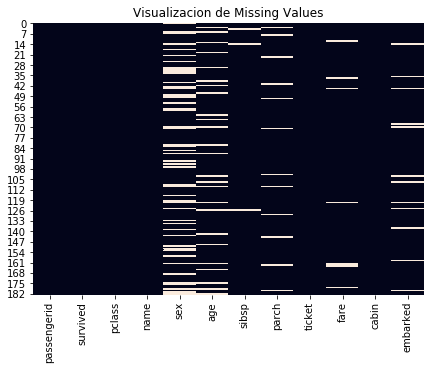

In [9]:
plt.figure(figsize=(7,5))
plt.title("Visualizacion de Missing Values")
sns.heatmap(titanic.isnull(),cbar=False)
plt.show()

In [11]:
# Faltantes en % para cada columna
df_md_perc = round(titanic.isnull().sum()/titanic.shape[0]*100,1)
print("Columnas Completas:",df_md_perc[df_md_perc==0].shape[0])
print("Columnas Incompletas:",df_md_perc[df_md_perc!=0].shape[0],"\n")
print("% de Missing Values por Columna")
df_md_perc

Columnas Completas: 6
Columnas Incompletas: 6 

% de Missing Values por Columna


passengerid     0.0
survived        0.0
pclass          0.0
name            0.0
sex            27.9
age            13.7
sibsp           1.6
parch           6.6
ticket          0.0
fare            4.4
cabin           0.0
embarked        6.6
dtype: float64

## **Descripcion Imputacion**

**sex**

In [12]:
titanic.sex.isnull().sum()

51

In [13]:
titanic.sex.unique()

array([nan, 'female', 'male'], dtype=object)

In [14]:
titanic.sex.value_counts()

male      68
female    64
Name: sex, dtype: int64

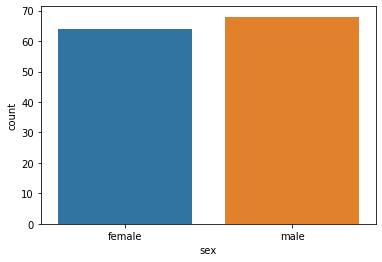

In [15]:
sns.countplot(titanic.sex)
plt.show()

Esta es la variable con mayor numero de missing values (casi un 30%) por esta razón imputarla de forma simple sesgaria demasiado mi data. En cambio ya a que esta variable puede depender de otros factores creo que la forma que elegiré para imputarla sera sectorized imputation. Adicionalmente, esta era la unica variable que tenia missing values pero como un string '?'. 

**age**

In [16]:
titanic.age.isnull().sum()

25

In [17]:
titanic.age.nunique()

58

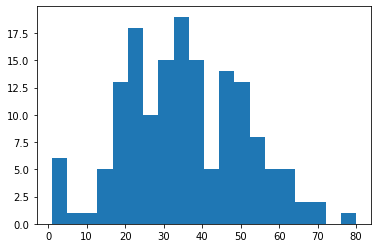

In [18]:
titanic.age.hist(grid=False,bins=20)
plt.show()

Es la segunda variable con más missing values (casi un 15%). La distribución parece tener una naturaleza acampanada por lo que eligire la media como metodo de imputación.

**sibsp**

In [19]:
titanic.sibsp.isnull().sum()

3

In [20]:
titanic.sibsp.unique()

array([ 1.,  0., nan,  3.,  2.])

In [21]:
titanic.sibsp.dtype

dtype('float64')

In [22]:
titanic.sibsp.value_counts()

0.0    109
1.0     62
2.0      6
3.0      3
Name: sibsp, dtype: int64

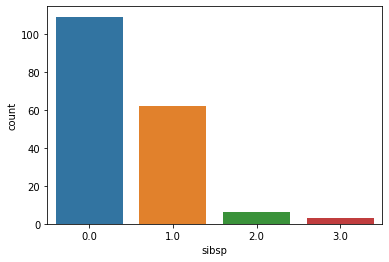

In [23]:
sns.countplot(titanic.sibsp)
plt.show()

No sé qué significa esta variable pero es categorica, puedo ver que hay un clase en especifico que es la más frecuente. Debido a que solo el 2% de mi información no tiene este valor voy a imputar esos datos con la moda.  Ademas, esta es una variable categorica pero con dtype float. La cabmiamos a *object*

In [24]:
titanic["sibsp"] = titanic["sibsp"].astype("object")

**parch**

In [25]:
titanic.parch.isnull().sum()

12

In [26]:
titanic.parch.unique()

array([ 0., nan,  2.,  1.,  4.])

In [27]:
titanic.parch.dtype

dtype('float64')

In [28]:
titanic.parch.value_counts()

0.0    116
1.0     33
2.0     21
4.0      1
Name: parch, dtype: int64

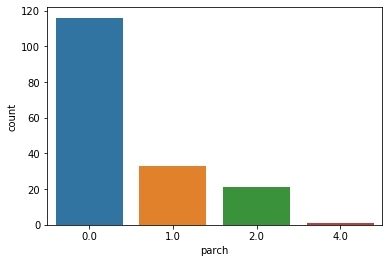

In [29]:
sns.countplot(titanic.parch)
plt.show()

Al igual que la variable *sibsp* esta variable es categorica pero con dtype float. La cabmiamos a *object*. Aca unevamente vemos que una clase predomina pero es más evidente que en la variable pasada. A pesar que mis valores faltantes son mayores aca (~6%) vamos a seguir la misma técnica que la variable pasada, imputar con la moda ya que se trata de una variable categorica.

In [30]:
titanic["parch"] = titanic["parch"].astype("object")

**fare**

In [31]:
titanic.fare.isnull().sum()

8

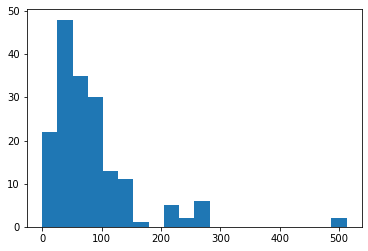

In [32]:
titanic.fare.hist(grid=False,bins=20)
plt.show()

A esta columna le hace falta el 4% de los datos. Puedo apreciar que es ua variable númerica pero a diferencia de mi otra columna númerica con missing values esta no exhibe un distribución acampanada. En su lugar, parece seguir una distribución exponencial por lo que voy a imputar esta variable con la mediana.

**embarked**

In [33]:
titanic.embarked.isnull().sum()

12

In [34]:
titanic.embarked.unique()

array(['C', 'S', nan, 'Q'], dtype=object)

In [35]:
titanic.embarked.value_counts()

S    110
C     59
Q      2
Name: embarked, dtype: int64

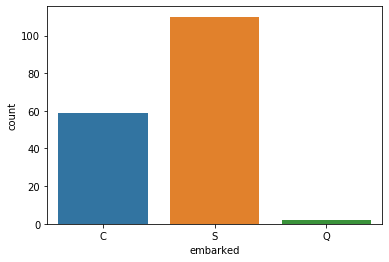

In [36]:
sns.countplot(titanic.embarked)
plt.show()

Esta es una variable categorica en donde la clase *S* predomina. Como se trata del 6% de mi data imputaré con la moda, es decir con *S*.

## **Descripcion Columnas Completas**

In [208]:
titanic.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

**passengerid**

In [209]:
titanic.passengerid.nunique()

183

ID unico para cada observacion

**survived**

In [214]:
titanic.survived.unique()

array([1, 0], dtype=int64)

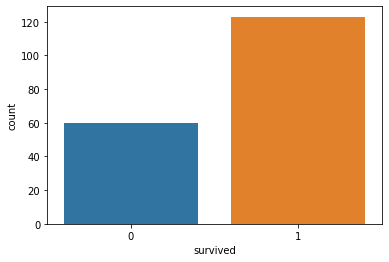

In [215]:
sns.countplot(titanic.survived)

Variable que parece decirnos quienes sobrevivieron y quienes no lo hicieron. Es categorica.

**pclass**

In [218]:
titanic.pclass.unique()

array([1, 3, 2], dtype=int64)

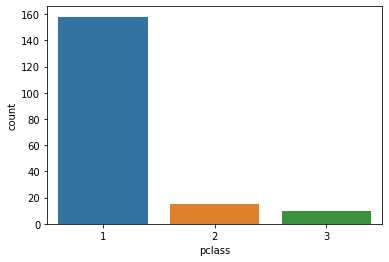

In [219]:
sns.countplot(titanic.pclass)

Variable categorica que describe la clase en el barco para cada pasajero.

**name**

In [221]:
titanic.name

0      Cumings, Mrs. John Bradley (Florence Briggs Th...
1           Futrelle, Mrs. Jacques Heath (Lily May Peel)
2                                McCarthy, Mr. Timothy J
3                        Sandstrom, Miss. Marguerite Rut
4                               Bonnell, Miss. Elizabeth
                             ...                        
178     Beckwith, Mrs. Richard Leonard (Sallie Monypeny)
179                             Carlsson, Mr. Frans Olof
180        Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)
181                         Graham, Miss. Margaret Edith
182                                Behr, Mr. Karl Howell
Name: name, Length: 183, dtype: object

In [222]:
titanic.name.nunique()

183

Nombre para cada uno de mis pasajeros. Es una variable tipo *string*. No hay nadie con nombre repetido.

**cabin**

In [224]:
titanic.cabin.nunique()

133

In [226]:
titanic.cabin.head()

0     C85
1    C123
2     E46
3      G6
4    C103
Name: cabin, dtype: object

Codigo de la cabina, asumo que en esta caso es la habitacion. No es unico, lo que hace sentido porque algunas personas puede que compartieran habitacion.

**ticket**

In [228]:
titanic.ticket.nunique()

127

In [230]:
titanic.ticket.head()

0    PC 17599
1      113803
2       17463
3     PP 9549
4      113783
Name: ticket, dtype: object

El codigo del ticket para los pasajeros, interesantemente tengo tickets repetidos lo que me hace pensar que probablemente algunos tickets podian usarse para más personas. Posiblemente familias.

## Aplicando Metodos

In [37]:
# Diccionario con Parametros de Columnas x Imputar
md_columns = {
                "sex":{"pair":"age"},
                "age":{"pair":"sex","lm":"fare"},
                "sibsp":{"pair":"parch"},
                "parch":{"pair":"sibsp"},
                "fare":{"pair":"embarked","lm":"age"},
                "embarked":{"pair":"fare"},
            }

In [171]:
results = {}
sectors = ["pclass","survived"] # Variables a usar en imputacion sectorizada
# Metodos para cada columna
for md_col in md_columns.keys():
    results[md_col] = {}
    numerical = False if titanic[md_col].dtype == "O" else True
    pair = md_columns[md_col]["pair"]
    results[md_col]["pairwise"] = pairwise(titanic,md_col,pair)
    results[md_col]["simple"] = simple_imputation(titanic,md_col,numerical)
    results[md_col]["sectorized"] = sectorized_imputation(titanic,sectors,md_col,numerical)
    if numerical:
        x_var = md_columns[md_col]["lm"]
        results[md_col]["lm"] = lm_imputation(titanic,x_var,md_col)
        results[md_col]["outliers"] = outliers(titanic,md_col)

## **Comparacion Imputaciones**

## **Pairwise:**

In [62]:
metodo = "pairwise"

### Age

In [63]:
variable = "age"

count    183.000000
mean      35.674426
std       15.643866
min        0.920000
25%       24.000000
50%       36.000000
75%       47.500000
max       80.000000
Name: age, dtype: float64 



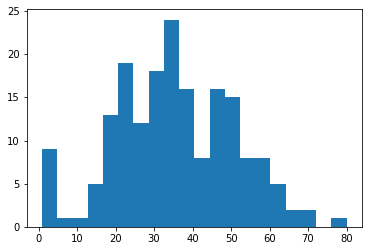

In [68]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    118.000000
mean      36.444237
std       15.198563
min        0.920000
25%       25.000000
50%       36.000000
75%       48.000000
max       80.000000
Name: age, dtype: float64 



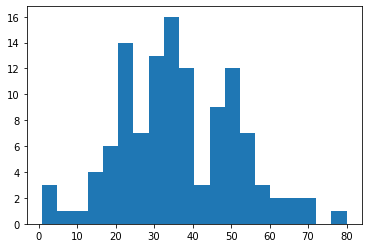

In [70]:
print(results[variable][metodo][variable].describe(),"\n")
results[variable][metodo][variable]hist(grid=False,bins=20)
plt.show()

### Fare

In [71]:
variable = "fare"

count    183.000000
mean      78.682469
std       76.347843
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64 



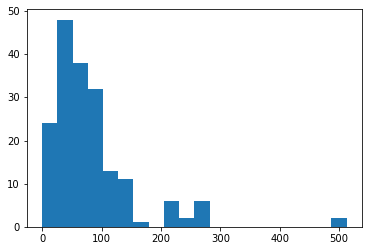

In [73]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    165.000000
mean      79.271238
std       78.803324
min        0.000000
25%       29.700000
50%       55.900000
75%       90.000000
max      512.329200
Name: fare, dtype: float64 



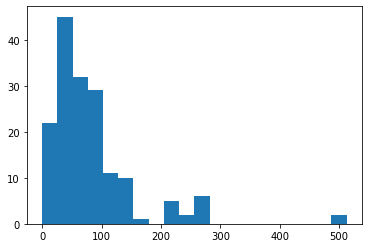

In [76]:
print(results[variable][metodo][variable].describe(),"\n")
results[variable][metodo][variable].hist(grid=False,bins=20)
plt.show()

### Sexo

In [80]:
variable = "sex"

male      95
female    88
Name: sex, dtype: int64 



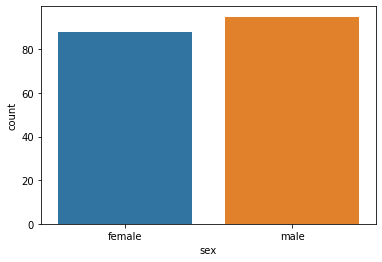

In [81]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

male      63
female    55
Name: sex, dtype: int64 



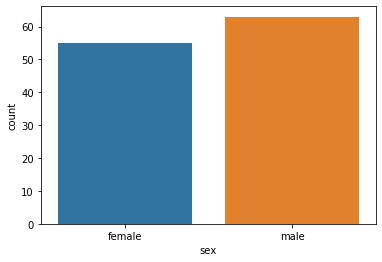

In [82]:
print(results[variable][metodo][variable].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable])
plt.show()

### Sibsp

In [83]:
variable = "sibsp"

0    110
1     64
2      6
3      3
Name: sibsp, dtype: int64 



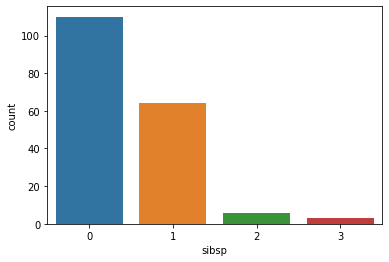

In [84]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

male      63
female    55
Name: sex, dtype: int64 



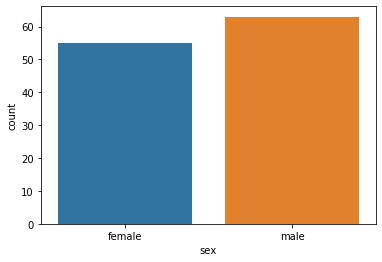

In [82]:
print(results[variable][metodo][variable].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable])
plt.show()

### Parch

In [86]:
variable = "parch"

0    122
1     37
2     23
4      1
Name: parch, dtype: int64 



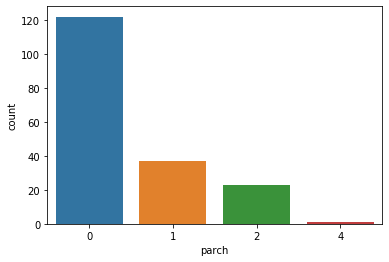

In [87]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

0.0    113
1.0     33
2.0     21
4.0      1
Name: parch, dtype: int64 



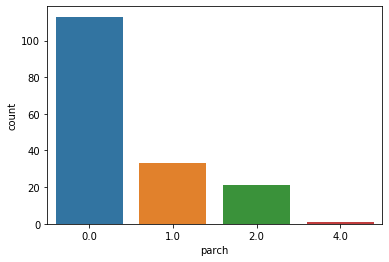

In [88]:
print(results[variable][metodo][variable].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable])
plt.show()

### Embarked

In [89]:
variable = "embarked"

S    116
C     65
Q      2
Name: embarked, dtype: int64 



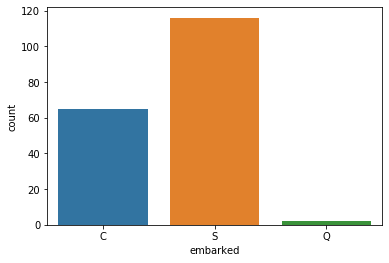

In [90]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

S    105
C     58
Q      2
Name: embarked, dtype: int64 



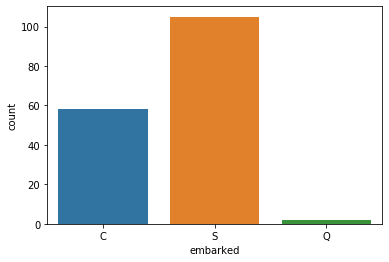

In [91]:
print(results[variable][metodo][variable].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable])
plt.show()

## **Imputacion generalizada:**

In [92]:
metodo = "simple"

### Age

In [93]:
variable = "age"

count    183.000000
mean      35.674426
std       15.643866
min        0.920000
25%       24.000000
50%       36.000000
75%       47.500000
max       80.000000
Name: age, dtype: float64 



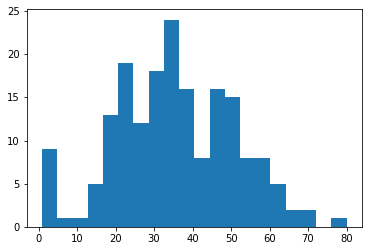

In [94]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    183.000000
mean      35.692532
std       14.526959
min        0.920000
25%       25.000000
50%       35.692532
75%       46.500000
max       80.000000
Name: age_mean_imputted, dtype: float64 



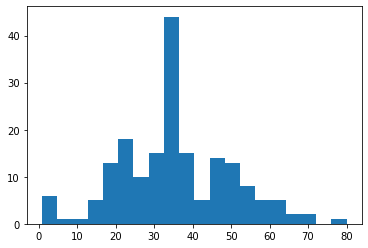

In [96]:
print(results[variable][metodo][variable+"_mean_imputted"].describe(),"\n")
results[variable][metodo][variable+"_mean_imputted"].hist(grid=False,bins=20) # Analizo solamente la que escogi previamente
plt.show()

### Fare

In [112]:
variable = "fare"

count    183.000000
mean      78.682469
std       76.347843
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64 



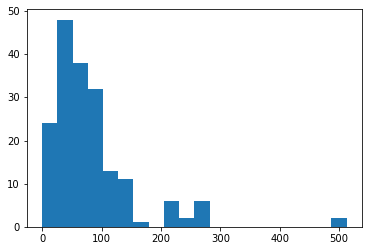

In [113]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    183.000000
mean      79.465438
std       75.351832
min        0.000000
25%       30.000000
50%       61.175000
75%       90.539600
max      512.329200
Name: fare_median_imputted, dtype: float64 



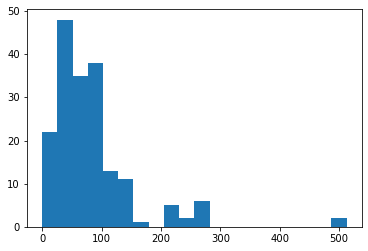

In [114]:
print(results[variable][metodo][variable+"_median_imputted"].describe(),"\n")
results[variable][metodo][variable+"_median_imputted"].hist(grid=False,bins=20)
plt.show()

### Sexo

In [115]:
variable = "sex"

male      95
female    88
Name: sex, dtype: int64 



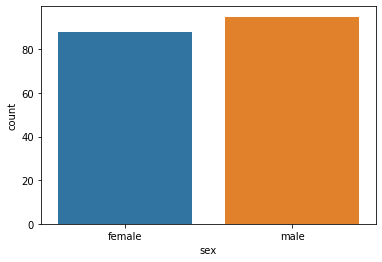

In [116]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

male      119
female     64
Name: sex_mode_imputted, dtype: int64 



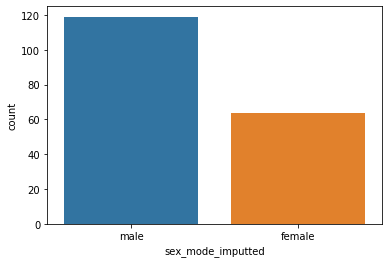

In [117]:
print(results[variable][metodo][variable+"_mode_imputted"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_mode_imputted"]) # Metodo que escogi
plt.show()

### Sibsp

In [118]:
variable = "sibsp"

0    110
1     64
2      6
3      3
Name: sibsp, dtype: int64 



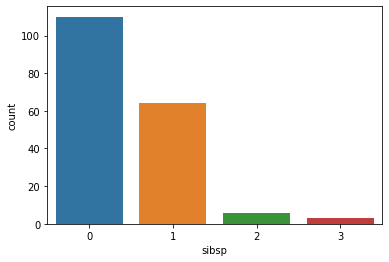

In [119]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

0.0    112
1.0     62
2.0      6
3.0      3
Name: sibsp_mode_imputted, dtype: int64 



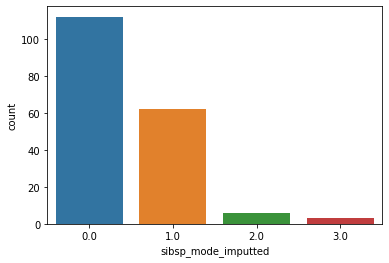

In [120]:
print(results[variable][metodo][variable+"_mode_imputted"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_mode_imputted"]) # Metodo que elegi
plt.show()

### Parch

In [121]:
variable = "parch"

0    122
1     37
2     23
4      1
Name: parch, dtype: int64 



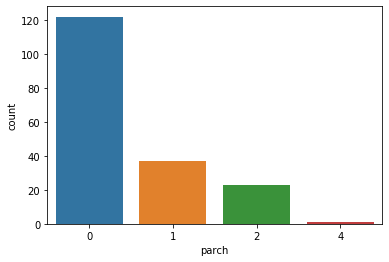

In [122]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

0.0    128
1.0     33
2.0     21
4.0      1
Name: parch_mode_imputted, dtype: int64 



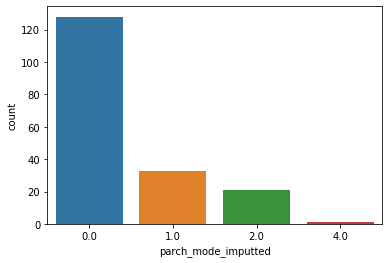

In [123]:
print(results[variable][metodo][variable+"_mode_imputted"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_mode_imputted"]) # Elegida
plt.show()

### Embarked

In [124]:
variable = "embarked"

S    116
C     65
Q      2
Name: embarked, dtype: int64 



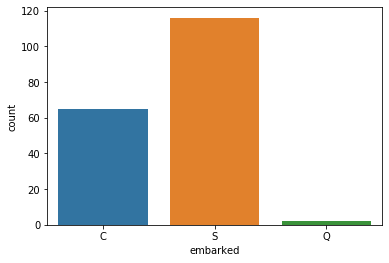

In [125]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

S    122
C     59
Q      2
Name: embarked_mode_imputted, dtype: int64 



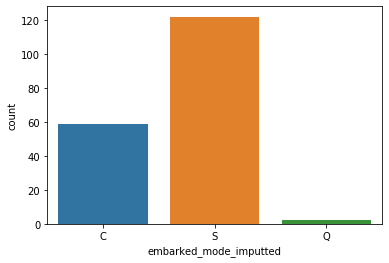

In [128]:
print(results[variable][metodo][variable+"_mode_imputted"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_mode_imputted"]) # Elegida
plt.show()

## **Imputacion sectorizada:**

In [129]:
metodo = "sectorized"

### Age

In [131]:
variable = "age"

count    183.000000
mean      35.674426
std       15.643866
min        0.920000
25%       24.000000
50%       36.000000
75%       47.500000
max       80.000000
Name: age, dtype: float64 



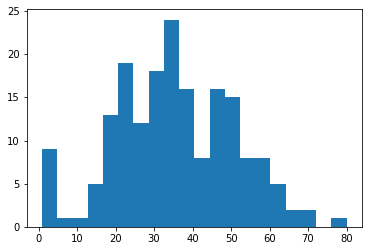

In [132]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    183.000000
mean      35.173914
std       14.796713
min        0.920000
25%       24.000000
50%       33.168302
75%       46.500000
max       80.000000
Name: age_sectorized_mean, dtype: float64 



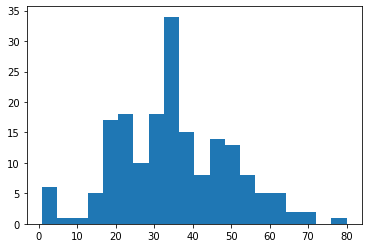

In [135]:
print(results[variable][metodo][variable+"_sectorized_mean"].describe(),"\n")
results[variable][metodo][variable+"_sectorized_mean"].hist(grid=False,bins=20) # Analizo solamente la que escogi previamente para la simple
plt.show()

### Fare

In [136]:
variable = "fare"

count    183.000000
mean      78.682469
std       76.347843
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64 



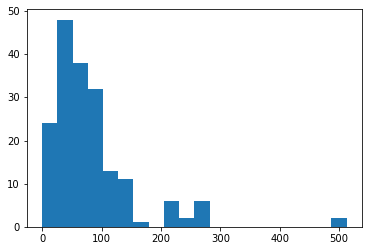

In [137]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    183.000000
mean      78.738946
std       75.660438
min        0.000000
25%       29.700000
50%       57.979200
75%       93.500000
max      512.329200
Name: fare_sectorized_median, dtype: float64 



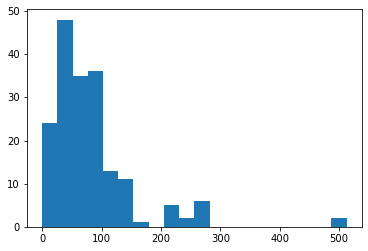

In [138]:
print(results[variable][metodo][variable+"_sectorized_median"].describe(),"\n")
results[variable][metodo][variable+"_sectorized_median"].hist(grid=False,bins=20) # SOlamente la que escogi en la simple
plt.show()

### Sexo

In [139]:
variable = "sex"

male      95
female    88
Name: sex, dtype: int64 



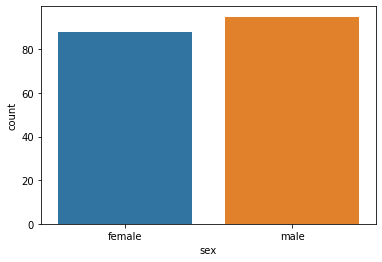

In [140]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

female    100
male       83
Name: sex_sectorized_mode, dtype: int64 



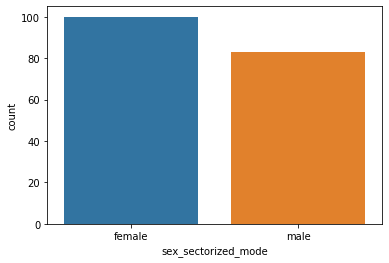

In [141]:
print(results[variable][metodo][variable+"_sectorized_mode"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_sectorized_mode"]) # Metodo que escogi
plt.show()

### Sibsp

In [142]:
variable = "sibsp"

0    110
1     64
2      6
3      3
Name: sibsp, dtype: int64 



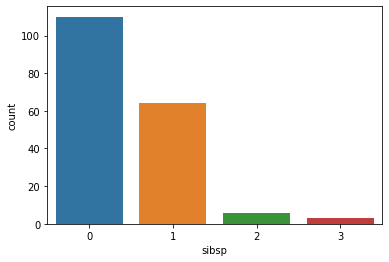

In [143]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

0.0    110
1.0     64
2.0      6
3.0      3
Name: sibsp_sectorized_mode, dtype: int64 



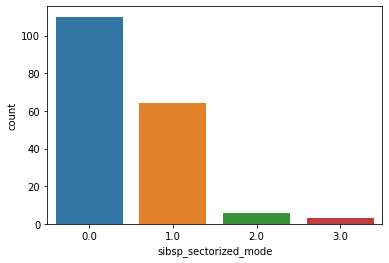

In [144]:
print(results[variable][metodo][variable+"_sectorized_mode"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_sectorized_mode"]) # Metodo que elegi
plt.show()

### Parch

In [145]:
variable = "parch"

0    122
1     37
2     23
4      1
Name: parch, dtype: int64 



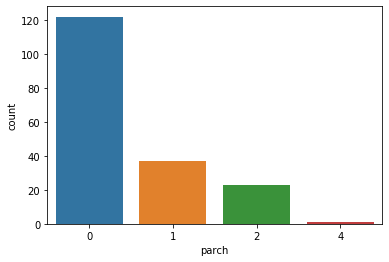

In [146]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

0.0    127
1.0     34
2.0     21
4.0      1
Name: parch_sectorized_mode, dtype: int64 



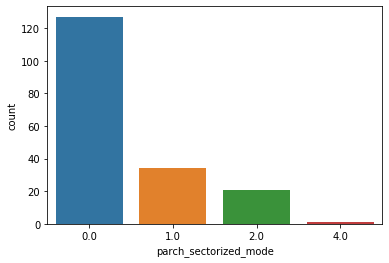

In [147]:
print(results[variable][metodo][variable+"_sectorized_mode"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_sectorized_mode"]) # Elegida
plt.show()

### Embarked

In [148]:
variable = "embarked"

S    116
C     65
Q      2
Name: embarked, dtype: int64 



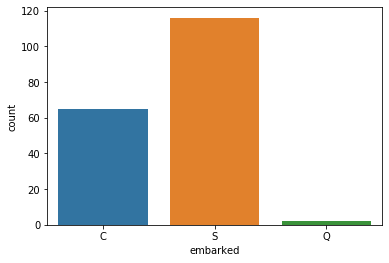

In [149]:
print(titanic_complete[variable].value_counts(),"\n")
sns.countplot(titanic_complete[variable])
plt.show()

S    122
C     59
Q      2
Name: embarked_sectorized_mode, dtype: int64 



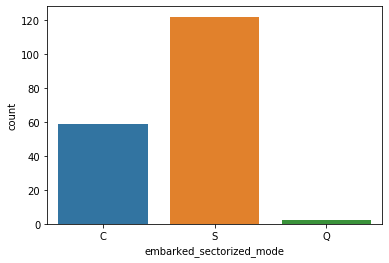

In [151]:
print(results[variable][metodo][variable+"_sectorized_mode"].value_counts(),"\n")
sns.countplot(results[variable][metodo][variable+"_sectorized_mode"]) # Elegida
plt.show()

## **Imputacion Regresion Lineal Simle:**

In [153]:
metodo = "lm"

### Age

In [154]:
variable = "age"

count    183.000000
mean      35.674426
std       15.643866
min        0.920000
25%       24.000000
50%       36.000000
75%       47.500000
max       80.000000
Name: age, dtype: float64 



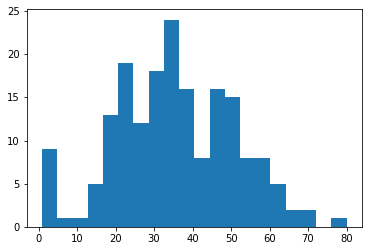

In [155]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    175.000000
mean      35.893086
std       14.738124
min        0.920000
25%       25.000000
50%       36.000000
75%       47.000000
max       80.000000
Name: age_lm_imputation, dtype: float64 



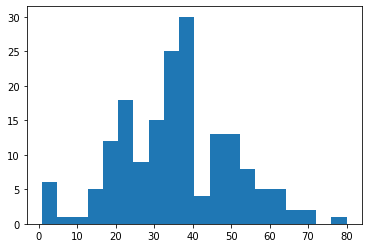

In [157]:
print(results[variable][metodo][variable+"_lm_imputation"].describe(),"\n")
# Como me faltan unas cols de la var. dep. no esta compl. imputado
results[variable][metodo][variable+"_lm_imputation"].hist(grid=False,bins=20) 
plt.show()

### Fare

In [158]:
variable = "fare"

count    183.000000
mean      78.682469
std       76.347843
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64 



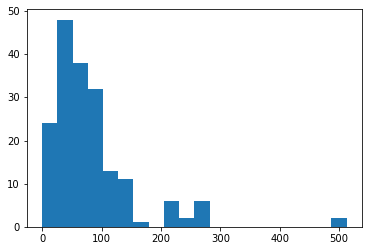

In [159]:
print(titanic_complete[variable].describe(),"\n")
titanic_complete[variable].hist(grid=False,bins=20)
plt.show()

count    158.000000
mean      81.604292
std       76.471325
min        0.000000
25%       30.548950
50%       66.600000
75%       91.079200
max      512.329200
Name: fare_lm_imputation, dtype: float64 



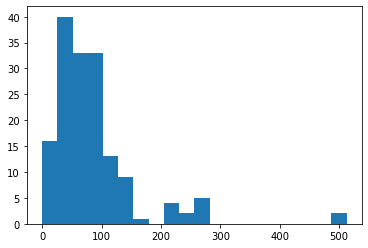

In [161]:
print(results[variable][metodo][variable+"_lm_imputation"].describe(),"\n")
# Como me faltan unas cols de la var. dep. no esta compl. imputado
results[variable][metodo][variable+"_lm_imputation"].hist(grid=False,bins=20) # SOlamente la que escogi en la simple
plt.show()

# **Conclusiones 1er Parte**

Observando estadisticos de tendencia central y observando las distribuciones de las variables completas y las imputadas puedo concluir que:
- **Imputacion Simple** funciono para las variables *sibsp*, *parch* y *embarked*. El hecho que la cantidad de NULLS aca fuera bajo y que hubiera una tendencia marcada (moda) permitio que una forma tan simple imputara bien cada variable.
- La variable de *sex* fue mejor imputada de **forma sectorizada**, lo cual hace mucho sentido y era lo que yo habia propuesto inicialmente.
- La variable de *fare* fue mejor imputada por el **metodo sectorizado**.
- La variable de *age* fue mejor imputada por el **modelo lineal** sin embargo una desventaja de esto es que si no cuento con la variable de edad y la variable independiente entonces no puedo imputar todas mis observaciones en algunos casos.

# **2nda Parte**

In [169]:
### NORMALIZATION
def minmax(df,col):
    min_val = df[col].min()
    max_val = df[col].max()
    
    df_norm = df.copy()
    df_norm[col] = (df_norm[col] - min_val)/(max_val - min_val)
    
    return df_norm[col]

def std_scaler(df,col):
    mean = df[col].mean()
    sigma = df[col].std()
    
    df_norm = df.copy()
    df_norm[col] = (df_norm[col] - mean)/sigma
    
    return df_norm[col]

def maxabs_scaler(df,col):
    max_abs = abs(df[col]).max()
    
    df_norm = df.copy()
    df_norm[col] = df_norm[col]/max_abs
    
    return df_norm[col]

## Normalizacion Age

count    183.000000
mean      35.674426
std       15.643866
min        0.920000
25%       24.000000
50%       36.000000
75%       47.500000
max       80.000000
Name: age, dtype: float64 



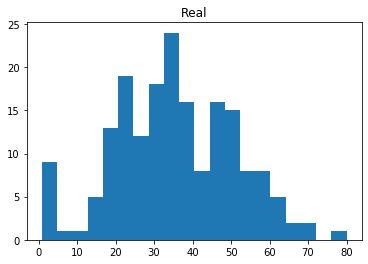

In [184]:
print(titanic_complete.age.describe(),"\n")
titanic_complete.age.hist(grid=False,bins=20)
plt.title("Real")
plt.show()

count    175.000000
mean       0.442249
std        0.186370
min        0.000000
25%        0.304502
50%        0.443601
75%        0.582701
max        1.000000
Name: age_lm_imputation, dtype: float64 



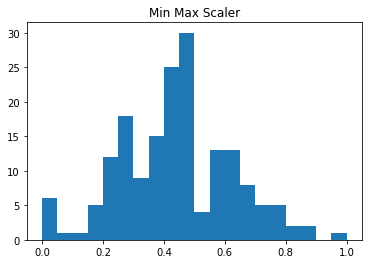

In [190]:
df_minmax = minmax(results["age"]["lm"],"age_lm_imputation")
print(df_minmax.describe(),"\n")
df_minmax.hist(grid=False,bins=20)
plt.title("Min Max Scaler")
plt.show()

count    1.750000e+02
mean    -2.283887e-17
std      1.000000e+00
min     -2.372967e+00
25%     -7.391094e-01
50%      7.254262e-03
75%      7.536179e-01
max      2.992709e+00
Name: age_lm_imputation, dtype: float64 



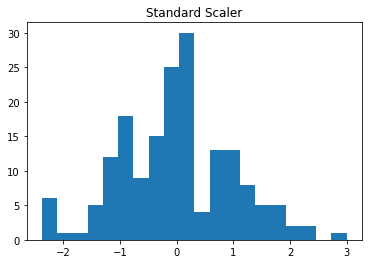

In [189]:
std_df = std_scaler(results["age"]["lm"],"age_lm_imputation")
print(std_df.describe(),"\n")
std_df.hist(grid=False,bins=20)
plt.title("Standard Scaler")
plt.show()

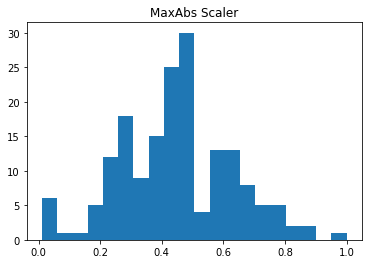

In [206]:
maxabs_scaler(results["age"]["lm"],"age_lm_imputation").hist(grid=False,bins=20)
plt.title("MaxAbs Scaler")
plt.show()

## Normalizacion Fare

count    183.000000
mean      78.682469
std       76.347843
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64 



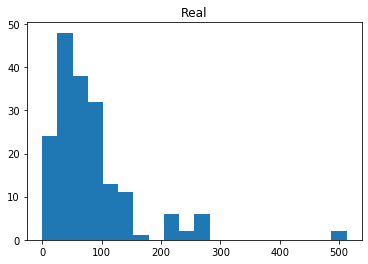

In [191]:
print(titanic_complete.fare.describe(),"\n")
titanic_complete.fare.hist(grid=False,bins=20)
plt.title("Real")
plt.show()

In [198]:
results["fare"]["sectorized"]["fare_sectorized_median"]

0      71.2833
1      53.1000
2      51.8625
3      16.7000
4      26.5500
        ...   
178    93.5000
179     5.0000
180    83.1583
181    30.0000
182    30.0000
Name: fare_sectorized_median, Length: 183, dtype: float64

count    183.000000
mean       0.153688
std        0.147679
min        0.000000
25%        0.057971
50%        0.113168
75%        0.182500
max        1.000000
Name: fare_sectorized_median, dtype: float64 



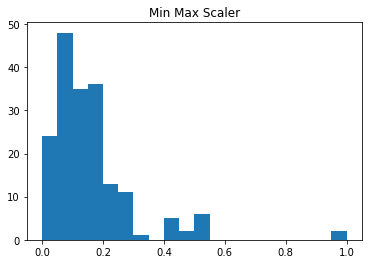

In [199]:
df_minmax = minmax(results["fare"]["sectorized"],"fare_sectorized_median")
print(df_minmax.describe(),"\n")
df_minmax.hist(grid=False,bins=20)
plt.title("Min Max Scaler")
plt.show()

count   183.00000
mean      0.00000
std       1.00000
min      -1.04069
25%      -0.64815
50%      -0.27438
75%       0.19510
max       5.73074
Name: fare_sectorized_median, dtype: float64 



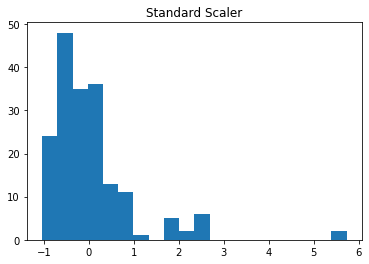

In [203]:
std_df = std_scaler(results["fare"]["sectorized"],"fare_sectorized_median")
print(std_df.describe(),"\n")
std_df.hist(grid=False,bins=20)
plt.title("Standard Scaler")
plt.show()

count   183.00000
mean      0.15369
std       0.14768
min       0.00000
25%       0.05797
50%       0.11317
75%       0.18250
max       1.00000
Name: fare_sectorized_median, dtype: float64 



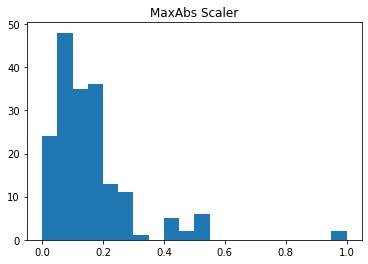

In [205]:
maxabs_df = maxabs_scaler(results["fare"]["sectorized"],"fare_sectorized_median")
print(maxabs_df.describe(),"\n")
maxabs_df.hist(grid=False,bins=20)
plt.title("MaxAbs Scaler")
plt.show()

# **Conclusiones 2nda Parte**

Al comparar las normalizaciones puedo cuncluir que realmente no existe diferencia evidente en este caso para los tres metodos que emplee. Realmente las variaciones en los estadisticos se deben al metodo empleado para imputar para cada variable asi como el rango de valores. Sin embargo, la normalizacion solamente cambio el rango de las variables (la finalidad de normalizar). Tanto MinMax como MaxAbs son muy parecidos ya que no estamos tratando con variables numericas que tenga valores negativos y ademas el minimo de mis variables era muy cercano a 0 por lo que al emplear MinMax estaba dividiendo cada valor,perturbado por el valor minimo que era cercano a cero, por un aproximado del maximo absoluto solamente perturbado por el valor minimo nuevamente. A menos a que mi modelo no pueda usar valores negativos como variable dependiente no veo preferenica clara entre MinMax/MaxAbs y Std.